# MOVIE PREDICTION

#### Part 1 : Data Exploration

##### Importing Packages

In [72]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

##### Loading in Data

In [73]:
prime_df = pd.read_csv('prime_titles.csv')
disney_df= pd.read_csv('disney_plus_shows.csv')
hulu_df=pd.read_csv('hulu_titles.csv')

In [74]:
prime_df = (prime_df.assign(service="amazon"))
disney_df = (disney_df.assign(service="disney"))
hulu_df = (hulu_df.assign(service="hulu"))

In [75]:
df=pd.concat([prime_df,disney_df,hulu_df],axis=0)

In [76]:
df.head()

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,...,added_at,genre,director,writer,actors,language,country,awards,metascore,imdb_rating
0,ts20945,The Three Stooges,SHOW,The Three Stooges were an American vaudeville ...,1934.0,TV-PG,19,"['comedy', 'family', 'animation', 'action', 'f...",['US'],26.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,tm19248,The General,MOVIE,"During America’s Civil War, Union spies steal ...",1926.0,NaN,78,"['action', 'drama', 'war', 'western', 'comedy'...",['US'],NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,tm82253,The Best Years of Our Lives,MOVIE,It's the hope that sustains the spirit of ever...,1946.0,NaN,171,"['romance', 'war', 'drama']",['US'],NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,tm83884,His Girl Friday,MOVIE,"Hildy, the journalist former wife of newspaper...",1940.0,NaN,92,"['comedy', 'drama', 'romance']",['US'],NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,tm56584,In a Lonely Place,MOVIE,An aspiring actress begins to suspect that her...,1950.0,NaN,94,"['thriller', 'drama', 'romance']",['US'],NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [77]:
df['genres'] = df['genres'].str.strip("[]'")

In [78]:
genres_df = df['genres'].str.split(', ', expand=True)

In [79]:
genres_df.columns = [f'genre_{i}' for i in range(genres_df.shape[1])]

In [80]:
df = pd.concat([df, genres_df], axis=1)

In [83]:
df['genre_0'] = df['genre_0'].str.strip("'")
df['genre_1'] = df['genre_1'].str.strip("'")
df['genre_2'] = df['genre_2'].str.strip("'")
df['genre_3'] = df['genre_3'].str.strip("'")
df['genre_4'] = df['genre_4'].str.strip("'")
df['genre_5'] = df['genre_5'].str.strip("'")
df['genre_6'] = df['genre_6'].str.strip("'")
df['genre_7'] = df['genre_7'].str.strip("'")
df['genre_8'] = df['genre_8'].str.strip("'")


In [84]:
df.head()

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,...,imdb_rating,genre_0,genre_1,genre_2,genre_3,genre_4,genre_5,genre_6,genre_7,genre_8
0,ts20945,The Three Stooges,SHOW,The Three Stooges were an American vaudeville ...,1934.0,TV-PG,19,"comedy', 'family', 'animation', 'action', 'fan...",['US'],26.0,...,NaN,comedy,family,animation,action,fantasy,horror,None,None,None
1,tm19248,The General,MOVIE,"During America’s Civil War, Union spies steal ...",1926.0,NaN,78,"action', 'drama', 'war', 'western', 'comedy', ...",['US'],NaN,...,NaN,action,drama,war,western,comedy,european,None,None,None
2,tm82253,The Best Years of Our Lives,MOVIE,It's the hope that sustains the spirit of ever...,1946.0,NaN,171,"romance', 'war', 'drama",['US'],NaN,...,NaN,romance,war,drama,None,None,None,None,None,None
3,tm83884,His Girl Friday,MOVIE,"Hildy, the journalist former wife of newspaper...",1940.0,NaN,92,"comedy', 'drama', 'romance",['US'],NaN,...,NaN,comedy,drama,romance,None,None,None,None,None,None
4,tm56584,In a Lonely Place,MOVIE,An aspiring actress begins to suspect that her...,1950.0,NaN,94,"thriller', 'drama', 'romance",['US'],NaN,...,NaN,thriller,drama,romance,None,None,None,None,None,None


##### Explanatory Data Analysis

In [ ]:
# Rating Distrubution 

<AxesSubplot:title={'center':'Count of Age Ratings'}, xlabel='age_certification'>

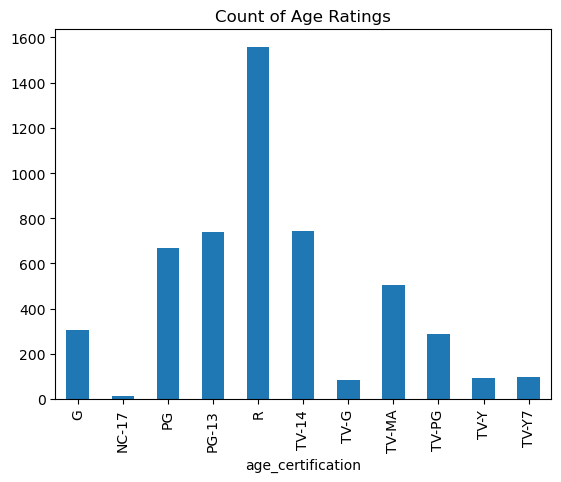

In [86]:
df.groupby(['age_certification']).size().plot.bar(title="Count of Age Ratings")

In [88]:
df.to_csv('data.csv', index=False)